In [1]:
import pandas as pd
import yfinance as yf
data1= yf.download('STI','2002-01-01','2019-09-15')
data2= yf.download('HBAN','2002-01-01', '2019-09-15')
data3= yf.download('^GSPC','2002-01-01', '2019-09-15')
data4= yf.download('^VIX','2002-01-01', '2019-09-15')
data5= yf.download('^IXIC','2002-01-01', '2019-09-15')
data=pd.DataFrame({'STI':data1['Close'],'HBAN':data2['Close'],'SP500':data3['Close'],'VIX':data4['Close'],'DOW':data5['Close']})

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [2]:
data['spread']=data['STI']-data['HBAN']

In [3]:
data.isnull().any()

data=data.fillna(1)

data2=data.copy()

data2.isnull().any()

STI       False
HBAN      False
SP500     False
VIX       False
DOW       False
spread    False
dtype: bool

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch.autograd import Variable

In [6]:
import numpy as np

In [44]:

def getState(t,data=data, window=30):
    if t - window >= -1:
        vec = data.iloc[t - window + 1:t + 1,:].to_numpy()
    else: 
        x = np.tile(data.iloc[0,:].to_numpy(), (window-t-1, 1))
        y = data.iloc[0: t + 1,:].to_numpy()
        vec = np.vstack((x,y))
    return vec.reshape(1,-1)

In [33]:
class Simulator(object):

    def __init__(self, data):

        # frame a time period as worl
        # initialize cash holdings
        init_cash = 100000

        #for visualization
        #self.data_out = data_out

        
        # first trading day
        self.dateIdx = 0
        #self.date = start_date
        #self.start_date = start_date
        #self.end_date = end_date

        self.data = data
        #self.stockA = data['STI']
        #self.stockB = data['HBAN']

        # keep track of portfolio value as a series
        self.portfolio = {'cash': init_cash, 'a_vol': [], 'a_price': [], 'b_vol': [], 'b_price': [], 'longA': 0}
        self.port_val = 100000

        
    def init_state(self):
        """
        return init states of the market
        """
        states = getState(0)
        self.dateIdx =0
        return states

    def step(self, action):

        buy_volume = 100
    
        if (action == 1):#buy
            if (self.portfolio['longA'] >= 0):

                
                long_cost = buy_volume * self.data.iloc[self.dateIdx,0]

                short_cost = buy_volume * self.data.iloc[self.dateIdx,1]

                total_cost = short_cost + long_cost

                self.portfolio['cash'] -= total_cost

                
                self.portfolio['a_vol'].append(buy_volume)
                self.portfolio['a_price'].append(self.data.iloc[self.dateIdx,0])
                self.portfolio['b_vol'].append(buy_volume)
                self.portfolio['b_price'].append(self.data.iloc[self.dateIdx,1])
                self.portfolio['longA'] = 1

                
                old_port_val = self.port_val
                self.port_val = self.port_value_for_output()

                reward = self.port_val - old_port_val
                

            else: #longA < 0 --> sell in reverse
                long_return = self.portfolio['b_vol'].pop(0) * self.data.iloc[self.dateIdx,1]              
                self.portfolio['b_price'].pop(0)
            
                short_return = self.portfolio['a_vol'][0] * self.portfolio['a_price'][0]
                short_return += (self.portfolio['a_vol'].pop(0) * (self.portfolio['a_price'].pop(0) -self.data.iloc[self.dateIdx,0]))

                
                new_cash = self.portfolio['cash'] + long_return + short_return
                self.portfolio['cash'] = new_cash
                self.portfolio['longA'] = -1 if (len(self.portfolio['a_vol']) > 0) else 0
                old_port_val = self.port_val
                self.port_val = self.port_value_for_output()
                reward = self.port_val - old_port_val
                
        elif (action == 2): #sell
            if (self.portfolio['longA'] > 0):
                long_return = self.portfolio['a_vol'].pop(0) *self.data.iloc[self.dateIdx,0] 
                self.portfolio['a_price'].pop(0)
                
                short_return = self.portfolio['b_vol'][0] * self.portfolio['b_price'][0]
                short_return += (self.portfolio['b_vol'].pop(0) * (self.portfolio['b_price'].pop(0) -self.data.iloc[self.dateIdx,1]))
                
                new_cash = self.portfolio['cash'] + long_return + short_return
                self.portfolio['cash'] = new_cash
                self.portfolio['longA'] = 1 if (len(self.portfolio['a_vol']) > 0) else 0
                old_port_val = self.port_val
                self.port_val = self.port_value_for_output()
                reward = self.port_val - old_port_val
            else: # longA <= 0 --> buy in reverse
                
                long_cost = buy_volume * self.data.iloc[self.dateIdx,0]
                short_cost = buy_volume * self.data.iloc[self.dateIdx,1]
                total_cost = short_cost + long_cost
                self.portfolio['cash'] -= total_cost
                self.portfolio['a_vol'].append(buy_volume)
                self.portfolio['a_price'].append(self.data.iloc[self.dateIdx,0])
                self.portfolio['b_vol'].append(buy_volume)
                self.portfolio['b_price'].append(-self.data.iloc[self.dateIdx,1])
                self.portfolio['longA'] = -1
                old_port_val = self.port_val
                self.port_val = self.port_value_for_output()
                reward = self.port_val - old_port_val
                
        else: #hold    
            old_port_val = self.port_val
            self.port_val = self.port_value_for_output()
            reward = self.port_val - old_port_val
        
        #self.data_out.append([self.port_val/100000-1,self.port_val])
        self.dateIdx += 1
        state = getState(self.dateIdx)

        if self.dateIdx < len(self.data.index)-1:
            done=False
        else:
            done =True
            print(self.port_val)
        return (state, reward, done)

    '''

    # calculate the current value of cash and stock holdings
    def port_value(self):
        value = self.portfolio['cash']
        if (len(self.portfolio['a_vol']) > 0):
            for i in range(len(self.portfolio['a_vol'])):
                value += (self.portfolio['a_vol'][i] * self.portfolio['a_price'][i])
        if (len(self.portfolio['b_vol']) > 0):
            for i in range(len(self.portfolio['b_vol'])):
                value += (self.portfolio['b_vol'][i] * self.portfolio['b_price'][i])
        return value
   '''
    # alternate calculation of the current value of cash and stock holdings
    def port_value_for_output(self):
        value = self.portfolio['cash']
        if (self.portfolio['longA'] > 0):
            value += (sum(self.portfolio['a_vol']) * self.data.iloc[self.dateIdx,0])
            for i in range(len(self.portfolio['b_vol'])):
                value += (self.portfolio['b_vol'][i] * self.portfolio['b_price'][i])
                value += (self.portfolio['b_vol'][i] * (self.portfolio['b_price'][i] - self.data.iloc[self.dateIdx,1]))
        if (self.portfolio['longA'] < 0):
            value += (sum(self.portfolio['b_vol']) * self.data.iloc[self.dateIdx,1])
            for i in range(len(self.portfolio['a_vol'])):
                value += (self.portfolio['a_vol'][i] * self.portfolio['a_price'][i])
                value += (self.portfolio['a_vol'][i] * (self.portfolio['a_price'][i] - self.data.iloc[self.dateIdx,0]))
        return value




In [34]:
N_S = 6*30
N_A = 3

In [35]:
N_KID = 10                  # half of the training population
N_GENERATION = 2000         # training step
LR = .05                    # learning rate
SIGMA = .05                 # mutation strength or step size
N_CORE = mp.cpu_count()-1


In [36]:
def v_wrap(np_array, dtype=np.float32):
    if np_array.dtype != dtype:
        np_array = np_array.astype(dtype)
    return torch.from_numpy(np_array)

In [37]:
class net(nn.Module):
    def __init__(self, s_dim, a_dim):
        super(net, self).__init__()
        
        self.fc1 = nn.Linear(s_dim,60)
        self.fc1.weight.data.normal_(0,1)
        self.fc2 = nn.Linear(60,20)
        self.fc2.weight.data.normal_(0,1)
        self.fc3 = nn.Linear(20,a_dim)
        self.fc3.weight.data.normal_(0,1)
        
    def forward(self, x):
        x=v_wrap(x)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        out = self.fc3(x)
        return out

    def choose_action(self, s):
        self.eval()
        logits = self.forward(s)
        prob = F.softmax(logits, dim=-1)
        return prob

In [38]:
def sign(k_id): return -1. if k_id % 2 == 0 else 1.  # mirrored sampling

In [39]:
class SGD(object):                      # optimizer with momentum
    def __init__(self, params, learning_rate, momentum=0.9):
        self.v = np.zeros(params).astype(np.float32)
        self.lr, self.momentum = learning_rate, momentum

    def get_gradients(self, gradients):
        self.v = self.momentum * self.v + (1. - self.momentum) * gradients
        return self.lr * self.v


In [40]:
def get_reward(network_param, num_p,env, seed_and_id=None,):
    # perturb parameters using seed
    if seed_and_id is not None:
        seed, k_id = seed_and_id
        # for layer in network.children():
        #     np.random.seed(seed)
        #     layer.weight.data += torch.FloatTensor(sign(k_id) * SIGMA * np.random.randn(layer.weight.shape[0],layer.weight.shape[1]))
        #     np.random.seed(seed)
        #     layer.bias.data += torch.FloatTensor(sign(k_id) * SIGMA * np.random.randn(layer.bias.shape[0]))
        np.random.seed(seed)
        params = torch.FloatTensor(sign(k_id) * SIGMA * np.random.randn(num_p))
        Net = net(N_S,N_A)
        Net.load_state_dict(network_param)
        for layer in Net.children():
            layer.weight.data += params[:layer.weight.shape[0]*layer.weight.shape[1]].view(layer.weight.shape[0],layer.weight.shape[1])
            layer.bias.data += params[layer.weight.shape[0]*layer.weight.shape[1]:layer.bias.shape[0]+layer.weight.shape[0]*layer.weight.shape[1]]
            params = params[layer.bias.shape[0]+layer.weight.shape[0]*layer.weight.shape[1]:]
    else:
        Net = net(N_S,N_A)
        Net.load_state_dict(network_param)
    # run episode
    s = env.init_state()
    ep_r = 0.
    done=False
    while(done==False):
        a = get_action(Net, s)
        s, r, done= env.step(a)
        
        ep_r += r
        
    return ep_r


def get_action(network, x):
    x = network.forward(x)
    return np.argmax(x.detach().numpy())      # for discrete action
   

In [41]:
def train(network_param, num_p,optimizer, utility, pool):
    # pass seed instead whole noise matrix to parallel will save your time
    noise_seed = np.random.randint(0, 2 ** 32 - 1, size=N_KID, dtype=np.uint32).repeat(2)    # mirrored sampling
    
    jobs = [pool.apply_async(get_reward, (network_param, num_p,env,
                                          [noise_seed[k_id], k_id], )) for k_id in range(N_KID*2)]

    rewards = np.array([j.get() for j in jobs])
    #sort reward
    kids_rank = np.argsort(rewards)[::-1]               # rank kid id by reward
    
    All_data = 0
    for ui, k_id in enumerate(kids_rank):
        np.random.seed(noise_seed[k_id])  # reconstruct noise using seed
        All_data += utility[ui] * sign(k_id) * np.random.randn(num_p)  # larger reward get bigger utility
       
    gradients = optimizer.get_gradients(All_data/(2*N_KID*SIGMA))
    gradients = torch.FloatTensor(gradients)

    for layer in network_param.keys():
        if 'weight' in layer:
            network_param[layer] += gradients[:network_param[layer].shape[0]*network_param[layer].shape[1]].view(network_param[layer].shape[0],network_param[layer].shape[1])
            gradients = gradients[network_param[layer].shape[0] * network_param[layer].shape[1]:]
        if 'bias' in layer:
            network_param[layer] += gradients[:network_param[layer].shape[0]]
            gradients = gradients[network_param[layer].shape[0]:]
    return network_param, rewards


In [55]:
import time
if __name__ == "__main__":
    # utility instead reward for update parameters (rank transformation)
    base = N_KID * 2    # *2 for mirrored sampling  number of kids
    rank = np.arange(1, base + 1)
    util_ = np.maximum(0, np.log(base / 2 + 1) - np.log(rank))
    utility = util_ / util_.sum() - 1 / base
    net_reward=[]
    kid_reward=[]
    # training
    Net_org = net(N_S,N_A).state_dict()
    #print(Net.fc1.weight.data[0][0])
    num_params = 0
    for r in list(Net_org):
        num_params+=Net_org[r].numel()
    env = Simulator(data2)
    optimizer = SGD(num_params, LR)
    pool = mp.Pool(processes=N_CORE)  # multiprocessing
    mar = None      # moving average reward
    for g in range(30):
        t0 = time.time()
        Net_org, kid_rewards = train(Net_org, num_params,optimizer, utility, pool)
        # update parameter
        # test trained net without noise
        net_r = get_reward(Net_org, num_params,env,  None,)
        mar = net_r if mar is None else 0.9 * mar + 0.1 * net_r       # moving average reward
        net_reward.append(net_r)
        kid_reward.append(mar)
        print(
            'Gen: ', g,
            '| Net_R: %.1f' % mar,
            '| Kid_avg_R: %.1f' % kid_rewards.mean(),
            '| Gen_T: %.2f' % (time.time() - t0),)


-5148138.0
5451296.0
-7116044.0
-7071152.0
-2607158.0
-5186292.0
-7414576.0
-7146202.0
2974318.0
-2282256.0
-7405410.0
-6658058.0
-7238814.0
-2462800.0
-2240898.0
1779392.0
-7044670.0
-2525654.0
-7404338.0
-6797886.0
-6009562.0
Gen:  0 | Net_R: -6109562.0 | Kid_avg_R: -4277267.0 | Gen_T: 560.63
-8384368.0
-13103202.0
-13531910.0
-7539294.0
-12649928.0
-8968998.0
-8499846.0
-10279218.0
-13512626.0
-12014076.0
-13484614.0
-8785882.0
-8702186.0
-12327898.0
-13078382.0
-13019568.0
-11840532.0
-13390588.0
-8529920.0
-13543676.0
-11403950.0
Gen:  1 | Net_R: -6038044.6 | Kid_avg_R: -5249773.6 | Gen_T: 1603.86
-17810064.0
-18025936.0
-17523606.0
-17485478.0
-18771718.0
-9464652.0
-6845170.0
-17996420.0
-16391416.0
-16334336.0
-18248512.0
-15011482.0
-18838712.0
-9344646.0
-18145794.0
-9247124.0
-9238174.0
-18936672.0
-18376148.0
-17123550.0
-15465048.0
Gen:  2 | Net_R: -5840349.9 | Kid_avg_R: -4054030.5 | Gen_T: 2598.25
-11237876.0
-11519610.0
-22563796.0
-18041238.0
-22833598.0
-22403070.0
-2

Process ForkPoolWorker-20:
Process ForkPoolWorker-21:
Process ForkPoolWorker-19:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocess

KeyboardInterrupt: 

  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py", line 3290, in _iget_item_cache
    def _iget_item_cache(self, item):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-40-60be18aff53b>", line 27, in get_reward
    s, r, done= env.step(a)
  File "<ipython-input-33-fbf00787d55c>", line 61, in step
    self.port_val = self.port_value_for_output()
  File "<ipython-input-33-fbf00787d55c>", line 146, in port_value_for_output
    value += (self.portfolio['b_vol'][i] * (self.portfolio['b_

In [56]:
data2

,STI,HBAN,VIX,spread,splog,dowlog
Date,,,,,,
2002-01-02,62.00,17.25,22.71,44.75,7.051570,7.590473
2002-01-03,62.30,17.45,21.34,44.85,7.060708,7.622796
2002-01-04,62.30,17.77,20.45,44.53,7.066902,7.630160
2002-01-07,62.38,17.71,21.94,44.67,7.060382,7.619283
2002-01-08,60.99,17.74,21.83,43.25,7.056787,7.628391
...,...,...,...,...,...,...
2019-09-09,64.97,14.17,15.27,50.80,7.999152,8.998068
2019-09-10,66.19,14.37,15.20,51.82,7.999474,8.997662
2019-09-11,67.28,14.61,14.61,52.67,8.006678,9.008185


In [58]:
env = Simulator(data2)
s=env.init_state() 
done=False
ep_r=0
while(done==False):
    net_test = net(180,3)
    net_test.load_state_dict(Net_org)
    a = get_action(net_test, s)
    s, r, done = env.step(a)
    ep_r+=r
print(ep_r)

7653466.0
7553466.0


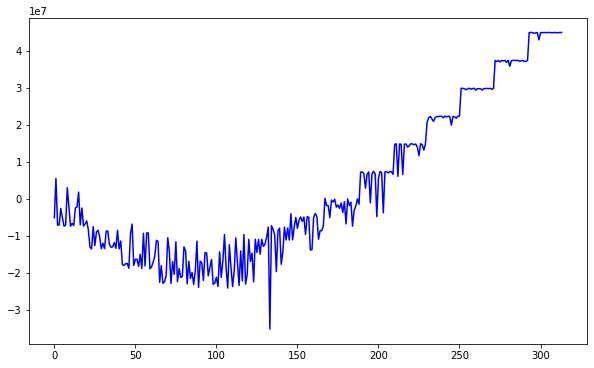

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(a,'b')
plt.show()

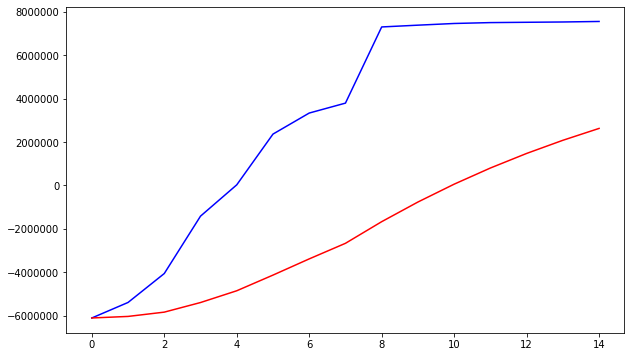

In [64]:
plt.figure(figsize=(10,6))
plt.plot(net_reward,'b',label="father's reward")
plt.plot(kid_reward,'r',label="kid's average reward")
plt.show()

In [22]:
data2['splog']=np.log(data.SP500)

data2['dowlog']=np.log(data.DOW)

data2=data2.drop(columns=['SP500','DOW'])

In [30]:
data2

,STI,HBAN,VIX,spread,splog,dowlog
Date,,,,,,
2002-01-02,62.00,17.25,22.71,44.75,7.051570,7.590473
2002-01-03,62.30,17.45,21.34,44.85,7.060708,7.622796
2002-01-04,62.30,17.77,20.45,44.53,7.066902,7.630160
2002-01-07,62.38,17.71,21.94,44.67,7.060382,7.619283
2002-01-08,60.99,17.74,21.83,43.25,7.056787,7.628391
...,...,...,...,...,...,...
2019-09-09,64.97,14.17,15.27,50.80,7.999152,8.998068
2019-09-10,66.19,14.37,15.20,51.82,7.999474,8.997662
2019-09-11,67.28,14.61,14.61,52.67,8.006678,9.008185
